In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np

from keras.layers import Input, Dense, Reshape, Dropout, Bidirectional, LSTM, TimeDistributed
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

from mido import Message, MidiFile, MidiTrack

Using TensorFlow backend.


In [0]:
datapath = 'drive/My Drive/NN/Capstone/classical_small'

In [0]:
songs_arr = np.load(datapath + '/songs_arr.npy', allow_pickle=True)
songs_arr.shape

(2001,)

In [0]:
seq_length = 100
n_features = 3
batch_size = 128
latent_dim = 10

In [0]:
## Generate sequences
notes_seq_in = []

for song in songs_arr:
  idx = 0
  while idx < song.shape[0] - seq_length - 1:
    seq = song[idx: idx + seq_length, :]
    notes_seq_in.append(seq)
    idx = idx + seq_length//2
    
notes_seq_in_arr = np.array(notes_seq_in)

In [0]:
num_batches = int(notes_seq_in_arr.shape[0]/batch_size)

In [0]:
num_batches

1422

## Preprocessing


*   Convert data from MIDI number to frequency
*   Normalize Notes from -1 to 1
*   Convert Intensity to a binary variable
*   Normalize Time from -1 to 1



In [0]:
notes_seq_in_arr_norm = np.zeros(notes_seq_in_arr.shape)

In [0]:
notes = notes_seq_in_arr[:, :, 0]
notes_to_freq = np.exp2((notes - 69)/12) * 440
freq_max = np.max(notes_to_freq)
freq_min = np.min(notes_to_freq)
notes_to_freq_norm = (notes_to_freq - freq_min) / (freq_max - freq_min)
notes_seq_in_arr_norm[:, :, 0] = notes_to_freq_norm

In [0]:
freq_min, freq_max

(8.175798915643707, 12543.853951415975)

In [0]:
len(notes)

182041

In [0]:
intensity = notes_seq_in_arr[:, :, 1]
intensity_norm = intensity / 127
notes_seq_in_arr_norm[:, :, 1] = intensity_norm

In [0]:
time = notes_seq_in_arr[:, :, 2]
time_max = np.max(time)
time_min = np.min(time)
time_norm = (time - time_min) / (time_max - time_min)
notes_seq_in_arr_norm[:, :, 2] = time_norm

# GAN

In [0]:
#Generator
def Generator(noise_dim, drop_rate):
    model = Sequential()
    model.add(Dense(512, input_dim = noise_dim))
    model.add(LeakyReLU(alpha=0.3))
    model.add(BatchNormalization())
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(drop_rate))
    model.add(Dense((seq_length*n_features),activation='sigmoid'))
    model.add(Reshape((seq_length, n_features)))
    return model

In [0]:
#Discriminator
def Discriminator(input_size):
    model = Sequential()
    model.add(LSTM(500, input_shape=input_size))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [0]:
disc = Discriminator((100, 3))
disc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
gen = Generator(10, 0.2)
gen.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
combined_gan = Sequential()
combined_gan.add(gen)
disc.trainable = False
combined_gan.add(disc)

In [0]:
combined_gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
%%time

# Adversarial ground truths
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# Store losses for analysis
disc_losses = []
gen_losses = []

# Training the model
for epoch in range(10):
  print("Epoch number " + str(epoch))
  
  batch_idx = np.random.randint(0, num_batches-1)
  
  # Generate random noise for generator
  noise = np.random.normal(0, 1, (batch_size, latent_dim))
    
  # Generate noisy sequences through generator
  gen_seqs = gen.predict(noise)
    
  # Train on real sequences
  d_loss_real = disc.train_on_batch(notes_seq_in_arr[batch_idx*batch_size:(batch_idx+1)*batch_size, :, :], real)
  
  # Train on noise
  d_loss_fake = disc.train_on_batch(gen_seqs, fake)
  
  print(d_loss_fake)
  
  # Compute total loss function
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
  # Compute generator loss keeping discriminator constant
  noise = np.random.normal(0, 1, (batch_size, latent_dim))
  g_loss = combined_gan.train_on_batch(noise, real)
  
  
  noise = np.random.normal(0, 1, (batch_size, latent_dim))
  gen_seqs = gen.predict(noise)
  
  test_batch_idx = np.random.randint(0, num_batches-1)
  d_loss_real_test = disc.test_on_batch(notes_seq_in_arr[test_batch_idx*batch_size:(test_batch_idx+1)*batch_size, :, :], real)
  
  # Train on noise
  d_loss_fake_test = disc.test_on_batch(gen_seqs, fake)
  
  d_loss_test = 0.5 * np.add(d_loss_real_test, d_loss_fake_test)
  
  noise = np.random.normal(0, 1, (batch_size, latent_dim))
  g_loss_test = combined_gan.test_on_batch(noise, real)
  
  disc_losses.append(d_loss_test[0])
  gen_losses.append(g_loss)
  
  #print("Discriminator Loss is " + str(disc_losses[-1]))
  #print("Generator Loss is " + str(gen_losses[-1]))

Text(0, 0.5, 'Loss')

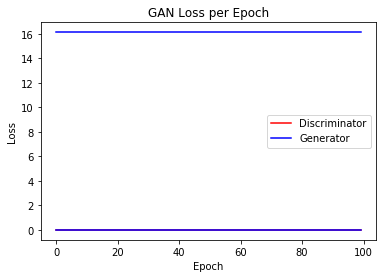

In [0]:
plt.plot(disc_losses, c='red')
plt.plot(gen_losses, c='blue')
plt.title("GAN Loss per Epoch")
plt.legend(['Discriminator', 'Generator'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [0]:
noise = np.random.normal(0, 1, (1, latent_dim))
gen_seqs = gen.predict(noise)

In [0]:
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)

for i in range(0, 100):
  track.append(Message('note_on', note=int(gen_seqs[i, 0]), time=int(gen_seqs[i, 2])))

mid.save(datapath + 'new_song.mid')

In [0]:
class GAN():
    
    def __init__(self, rows):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 3)
        self.latent_dim = 100
        self.disc_loss_real = []
        self.disc_loss_fake = []
        self.gen_loss =[]
        
        #optimizer_disc = Adam(0.00003)
        #optimizer_gen = Adam(0.0003)
        optimizer_disc = Adam(0.0001)
        optimizer_gen = Adam(0.001)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_disc, metrics=['accuracy'])

        # Build the generator
        #self.generator = self.build_generator()
        self.generator = self.build_generator_lstm()
        
        # The generator takes noise as input and generates note sequences
        #z = Input(shape=(self.latent_dim, ))
        z = Input(shape=(self.latent_dim,1))
        generated_seq = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated_seq)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer_gen)

        
    def build_discriminator(self):

        model = Sequential()
        model.add(LSTM(512, input_shape=self.seq_shape))
        #model.add(Bidirectional(LSTM(512)))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        seq = Input(shape=self.seq_shape)
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.seq_shape), activation='sigmoid'))
        model.add(Reshape(self.seq_shape))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)
      
      
    def build_generator_lstm(self):
      
      model = Sequential()
      model.add(LSTM(256, input_shape=(self.latent_dim, 1), return_sequences=True))
      model.add(Dropout(0.3))
      model.add(LeakyReLU(alpha=0.2))
      #model.add(Bidirectional(LSTM(256, return_sequences=True)))
      model.add(TimeDistributed(Dense(512)))
      model.add(TimeDistributed(LeakyReLU(alpha=0.2)))
      model.add(TimeDistributed(BatchNormalization(momentum=0.8)))
      model.add(TimeDistributed(Dense(3)))
      
      model.summary()
        
      noise = Input(shape=(self.latent_dim, 1))
      seq = model(noise)

      return Model(noise, seq)
      
      

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load and convert the data
        X_train = notes_seq_in_arr_norm

        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        seqs_list = []
        
        # Training the model
        for epoch in range(epochs):
          
#             if epoch % 5 == 0:
#               self.discriminator.trainable = True
#             else:
#               self.discriminator.trainable = False

            # Training the discriminator
            # Select a random batch of note sequences
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            #print(idx)
            real_seqs = X_train[idx]
            #print("shape: ", real_seqs.shape)
            #noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim, 1))
            
            #print(noise.shape)
      
            # Generate a batch of new note sequences
            gen_seqs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Training the Generator
            #noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim, 1))
            

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)
            
            if d_loss[0] < 0.7 * g_loss:
              self.discriminator.trainable = False
              self.generator.trainable = True
            elif g_loss < 0.7 * d_loss[0]:
              self.discriminator.trainable = True
              self.generator.trainable = False
            else:
              self.discriminator.trainable = True
              self.generator.trainable = True

            # Print the progress and save into loss lists
            if epoch % sample_interval == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              #self.generator.save(datapath + "final_model"+str(epoch)+".hdf5")
              #noise = np.random.normal(0, 1, (1, 100, 1)) 
              #seqs_list.append(self.generator.predict(noise))
            
            #if epoch % 5 == 0:
            self.disc_loss_real.append(d_loss[0])
            self.disc_loss_fake.append(d_loss[1])
            self.gen_loss.append(g_loss)
        
        #self.generate(notes)
        self.plot_loss()
        return seqs_list
        
    def plot_loss(self):
        plt.plot(self.disc_loss_real, c='dodgerblue')
        plt.plot(self.disc_loss_fake, c='orange')
        plt.plot(self.gen_loss, c='green')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator(Real)', 'Discriminator(Fake)', 'Generator'], loc="best")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig(datapath + 'loss_epoch_lstm.png', transparent=True)
        plt.close()

In [0]:
gan = GAN(rows=100)    
final_seqs= gan.train(epochs=2500, batch_size=128, sample_interval=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 512)               1056768   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 1,188,353
Trainable params: 1,188,353
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.701868, acc.: 33.20%] [G loss: 0.693907]
5 [D loss: 0.649026, acc.: 97.27%] [G loss: 0.778669]
10 [D loss: 0.592083, acc.: 98.83%] [G loss: 0.925906]
15 [D loss: 0.453583, acc.: 99.61%] [G loss: 1.608199]
20 [D loss: 0.087623, acc.: 100.00%] [G loss: 10.686011]
25 [D loss: 0.502659, acc.: 91.02%] [G loss: 10.676782]
30 [D loss: 0.490210, acc.: 82.81%] [G loss: 9.220753]
35 [D loss: 0.469845, acc.: 80.86%] [G loss: 7.199968]
40 [D loss: 0.470490, acc.: 77.34%] [G loss: 5.904325]
45 [D loss: 0.445944, acc.: 80.08%] [G loss: 5.435566]
50 [D loss: 0.462598, acc.: 78.12%] [G loss: 6.340213]
55 [D loss: 0.487375, acc.: 75.78%] [G loss: 5.935518]
60 [D loss: 0.453437, acc.: 77.73%] [G loss: 6.023584]
65 [D loss: 0.740699, acc.: 75.78%] [G loss: 4.185201]
70 [D loss: 0.494976, acc.: 73.44%] [G loss: 2.347134]
75 [D loss: 0.495910, acc.: 73.44%] [G loss: 2.106502]
80 [D loss: 0.426146, acc.: 80.47%] [G loss: 2.547625]
85 [D loss: 0.446033, acc.: 76.56%] [G loss: 2.367205]
90 [D los

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "middle right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


In [0]:
len(final_seqs)

50

In [0]:
gan_t = GAN(rows=100)
discriminator = gan_t.build_discriminator()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               1056768   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)      

In [0]:
from keras.utils import plot_model  
plot_model(gan.combined, to_file= datapath + '/fcn-gen-arch.png')
#plot_model(gan.discriminator, to_file= datapath + 'fcn-disc-arch.png')

In [0]:
gan_crnn = GAN(rows=100)
gan_crnn.train(epochs=100, batch_size=128, sample_interval=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               1056768   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)      

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.693582, acc.: 22.27%] [G loss: 0.688059]
1 [D loss: 0.693943, acc.: 67.19%] [G loss: 0.690330]
2 [D loss: 0.686971, acc.: 71.48%] [G loss: 0.667248]
3 [D loss: 0.687251, acc.: 72.27%] [G loss: 0.693699]
4 [D loss: 0.686737, acc.: 70.31%] [G loss: 0.696602]
5 [D loss: 0.666245, acc.: 73.83%] [G loss: 0.684420]
6 [D loss: 0.669571, acc.: 67.97%] [G loss: 0.674589]
7 [D loss: 0.670496, acc.: 70.70%] [G loss: 0.699576]
8 [D loss: 0.688478, acc.: 68.75%] [G loss: 0.664483]
9 [D loss: 0.719150, acc.: 60.94%] [G loss: 0.649559]
10 [D loss: 0.749386, acc.: 58.20%] [G loss: 0.653076]
11 [D loss: 0.796250, acc.: 54.30%] [G loss: 0.637054]
12 [D loss: 0.862844, acc.: 50.39%] [G loss: 0.599177]
13 [D loss: 1.035884, acc.: 50.00%] [G loss: 0.540412]
14 [D loss: 1.260517, acc.: 50.00%] [G loss: 0.366108]
15 [D loss: 1.108932, acc.: 53.12%] [G loss: 0.321867]
16 [D loss: 0.924398, acc.: 59.38%] [G loss: 0.419933]
17 [D loss: 0.811818, acc.: 63.28%] [G loss: 0.498268]
18 [D loss: 0.717024

[]

In [0]:
gg = gan_crnn.disc_loss_fake

[0.22265625,
 0.671875,
 0.71484375,
 0.72265625,
 0.703125,
 0.73828125,
 0.6796875,
 0.70703125,
 0.6875,
 0.609375,
 0.58203125,
 0.54296875,
 0.50390625,
 0.5,
 0.5,
 0.53125,
 0.59375,
 0.6328125,
 0.73828125,
 0.82421875,
 0.76953125,
 0.7265625,
 0.7734375,
 0.6328125,
 0.671875,
 0.69140625,
 0.75,
 0.7734375,
 0.7578125,
 0.77734375,
 0.75,
 0.7421875,
 0.76171875,
 0.796875,
 0.8671875,
 0.84375,
 0.84765625,
 0.84375,
 0.8359375,
 0.890625,
 0.9296875,
 0.96875,
 0.9765625,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [0]:

plt.plot(gan_crnn.disc_loss_real[:75], c='dodgerblue')
#plt.plot(gan_crnn.disc_loss_fake[:74], c='orange')
plt.plot(gan_crnn.gen_loss[:75], c='green')
plt.title("GAN Loss per Epoch")
plt.legend(['Discriminator', 'Generator'], loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(datapath + 'loss_epoch_lstm.png', transparent=True)
plt.close()

In [0]:
noise = np.random.normal(0, 1, (1, 100, 1))
gen_seqs = gan_crnn.generator.predict(noise)
gen_seqs = gen_seqs.reshape(100, 3)

In [0]:
gen_seq_denorm = np.zeros(gen_seqs.shape)

In [0]:
gen_seq_denorm[:, 0] = (gen_seqs[:, 0] * (freq_max - freq_min)) + freq_min

In [0]:
gen_seq_denorm[:, 1] = (gen_seqs[:, 1] * 127)

In [0]:
gen_seq_denorm[:, 2] = (gen_seqs[:, 2] * (time_max - time_min)) + time_min

In [0]:
(gen_seqs[:, 2] < -1).any() == True

False

In [0]:
a, b = get_scale_consistency(gen_seq_denorm[:, 0], 13, 107)
b

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log2
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


0.31

In [0]:
repetitions(a.astype(int), rep_min=1, rep_max=5)

{1: 13}

In [0]:
tone_span(a.astype(int))

120

In [0]:
tone_var(a.astype(int))

24

In [0]:
for i in range(0, 10):
  
  mid = MidiFile()
  track = MidiTrack()
  mid.tracks.append(track)  
  
  noise = np.random.normal(0, 1, (1, 100, 1))
  gen_seqs = gan_crnn.generator.predict(noise)
  gen_seqs = gen_seqs.reshape(100, 3)
  gen_seq_denorm = np.zeros(gen_seqs.shape)
  gen_seq_denorm[:, 0] = (gen_seqs[:, 0] * (freq_max - freq_min)) + freq_min
  a, b = get_scale_consistency(gen_seq_denorm[:, 0], 13, 107)
  a = a.astype(int)
  gen_seq_denorm[:, 1] = (gen_seqs[:, 1] * 127).astype(int)
  gen_seq_denorm[:, 2] = (gen_seqs[:, 2] * (time_max - time_min)) + time_min
  
  for i in range(0, len(a)):
    track.append(Message('note_on', note= a[i], velocity=100, time=200))

  mid.save(datapath + 'new_song_crnn' + str(i) + '.mid')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log2
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


ValueError: ignored

In [0]:
type(gen_seqs)

numpy.ndarray

# Statistical Evaluation of Generated Music



*   **Scale Consistency** :  Fraction of tones that were part of a standard scale.
*   **Repetitions**: Count of the number of repeated
short subsequences where a score is given based on the
amount of recurrence.
*  **Tone Span**: Measure of the number of half-
tone steps between the lowest and the highest tone in a
sample.
*  **Tone variation**: Number of different tones in the generated sequence  



In [0]:
def get_scale_consistency(generated_tones_freq, min_midi_no, max_midi_no):
  midi_numbers = 12 * np.log2(generated_tones_freq / 440) + 69
  unmatched = np.sum(midi_numbers < min_midi_no) + np.sum(midi_numbers > max_midi_no)
  midi_numbers_float = midi_numbers - midi_numbers.astype(int)
  matched_vals_low = midi_numbers_float < 0.45
  matched_vals_high = midi_numbers_float > 0.55
  matched_vals = np.logical_or(matched_vals_low, matched_vals_high)
  return midi_numbers[matched_vals], (len(midi_numbers[matched_vals])) / len(generated_tones_freq)

In [0]:
def repetitions(matched_tones, rep_min, rep_max):
  rs = {}
  for l in range(rep_min, rep_max):
    rs[l] = 0
    for i in range(len(matched_tones)-l*2):
      for j in range(i+l,len(matched_tones)-l):
        if np.array_equal(matched_tones[i:i+l], matched_tones[j:j+l]):
          rs[l] += 1
  rs2 = {}
  for r in rs:
    if rs[r]:
      rs2[r] = rs[r]
  return rs2

In [0]:
def tone_span(tones):
  return np.max(tones) - np.min(tones)

In [0]:
def tone_var(tones):
  return len(np.unique(tones))

In [0]:
a, b = get_scale_consistency(gen_seq_denorm[:, 0], 13, 107)
b

0.93

In [0]:
repetitions(a.astype(int), rep_min=2, rep_max=5)

{2: 4, 3: 1}

In [0]:
tone_span(a.astype(int))

55

In [0]:
tone_var(a.astype(int))

37

In [0]:
#model = load_model("model-10.hdf5")

In [0]:
for i in range(0, 10):
  
  mid = MidiFile()
  track = MidiTrack()
  mid.tracks.append(track)  
  b_val = []
  tone_span_val = []
  tone_var_list = []
  rep_list = []
  
  for gen_seqs in final_seqs:
      gen_seqs = gen_seqs.reshape(100, 3)
      gen_seq_denorm = np.zeros(gen_seqs.shape)
      gen_seq_denorm[:, 0] = (gen_seqs[:, 0] * (freq_max - freq_min)) + freq_min
      a, b = get_scale_consistency(gen_seq_denorm[:, 0], 13, 107)
      a = a.astype(int)
      b_val.append(b)
      #print(repetitions(a.astype(int), rep_min=2, rep_max=5))
      gen_seq_denorm[:, 1] = (gen_seqs[:, 1] * 127).astype(int)
      gen_seq_denorm[:, 2] = (gen_seqs[:, 2] * (time_max - time_min)) + time_min
      tone_span_val.append(tone_span(a.astype(int)))
      tone_var_list.append(tone_var(a.astype(int)))
      rep_list.append(repetitions(a.astype(int), rep_min=2, rep_max=5))
      for i in range(0, len(a)):
        track.append(Message('note_on', note= a[i], velocity=100, time=200))

      mid.save(datapath + 'new_song' + str(i) + '.mid')

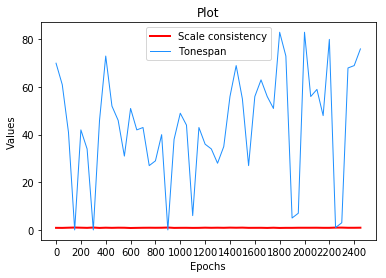

In [0]:
def plot_values1(b_val, tone_span_val, tone_var_list):
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    plt.xlabel("Epochs")
    plt.ylabel("Values")
    plt.xticks(range(0, 2500, 200))
    y = range(0, 2500, 50)
    
    #c1 = plt.plot(y, np.squeeze(input_node), color="orange", label="input_node")
    #c2 = plt.plot(y, np.squeeze(internal_state), color="teal", label="internal_state")
    #c2 = plt.plot(y, np.squeeze(input_gate), color="blue", label="input_gate")
    c1 = plt.plot(y, np.squeeze(b_val), color="red", label="Scale consistency", linewidth=2.0)
    c2 = plt.plot(y, np.squeeze(tone_span_val), color="dodgerblue", label="Tonespan", linewidth=1.0)
    ax.legend()
    plt.title("Plot")
    #plt.savefig(filename)
    plt.show()
    
plot_values1(b_val, tone_span_val, tone_var_list)

In [0]:
b_val

[0.87,
 0.85,
 0.93,
 1.0,
 0.93,
 0.87,
 1.0,
 0.84,
 0.93,
 0.87,
 0.93,
 0.91,
 0.81,
 0.86,
 0.9,
 0.92,
 0.9,
 0.92,
 1.0,
 0.85,
 0.88,
 0.89,
 0.85,
 0.87,
 0.94,
 0.89,
 0.93,
 0.89,
 0.96,
 0.92,
 0.96,
 0.87,
 0.88,
 0.89,
 0.84,
 0.92,
 0.83,
 0.87,
 0.87,
 0.91,
 0.91,
 0.91,
 0.92,
 0.88,
 0.88,
 0.97,
 0.97,
 0.9,
 0.9,
 0.93]

In [0]:
for i in final_seqs:
    print(i)
    break

[[[0.7998696  0.9530449  0.84937096]
  [0.15825713 0.3300386  0.45573384]
  [0.6101406  0.2875145  0.7044674 ]
  [0.6011729  0.40458614 0.16909906]
  [0.8104598  0.76960146 0.28276697]
  [0.4895568  0.6299223  0.14528283]
  [0.28941417 0.6289892  0.4558926 ]
  [0.44848385 0.61190724 0.48667514]
  [0.9077398  0.3615174  0.50546217]
  [0.16157082 0.6962994  0.69297093]
  [0.8122356  0.0809851  0.1408329 ]
  [0.19495451 0.42973825 0.16819993]
  [0.75539356 0.24683535 0.58806515]
  [0.22783676 0.79877037 0.69564563]
  [0.65882087 0.6676462  0.9434037 ]
  [0.73815566 0.7785399  0.31890368]
  [0.2978382  0.9436167  0.15086755]
  [0.46249306 0.9011998  0.31297988]
  [0.31169719 0.4616465  0.5049339 ]
  [0.51182187 0.35532343 0.17128637]
  [0.89728934 0.8039422  0.2912392 ]
  [0.20464322 0.46452183 0.604581  ]
  [0.9063872  0.21232137 0.7800156 ]
  [0.67100614 0.08472264 0.06041312]
  [0.01634327 0.06280741 0.35441184]
  [0.26210845 0.47217837 0.24281037]
  [0.0555031  0.2092371  0.28236604]
 